# Lesson 4: Geometry Transformation Continues...
___

## 2. Rotational Transformation

For rotational transformation, it has 2 important things:
1. Center of rotation (Center of the coordinate system)
1. Angle of rotation (CW or CCW)

**Matrix of Rotation.**
<p style="text-align:center; color:blue">$P' = RP$ </p>
<p style="text-align:center">
$
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
 = 
\begin{bmatrix}
cos\theta & -sin\theta \\
sin\theta & cos\theta
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
$
</p>

#### Prove that Rotation is a linear transformation.
$$
\theta = (\phi + \theta) \\[5mm]
x_1 = \gamma cos\theta \\
y_1 = \gamma sin\theta \\[5mm]
x' = \gamma cos(\phi + \theta) \\
= \gamma(cos\phi cos\theta - sin\phi sin\theta) --- trig. identity \\[5mm]
y' = \gamma sin(\phi + \theta) \\
= \gamma(sin\phi cos\theta + cos\phi sin\theta) --- trig. identity \\[5mm]
x' = x_1cos\theta - y_1sin\theta \\
y' = x_1sin\theta + y_1cos\theta
$$

### 2.1 Index Shifting

![image](../images/indexing.png)

* Coordinates

$
A \begin{bmatrix}
    0 \\
    0 
\end{bmatrix} B \begin{bmatrix}
    0 \\
    199 
\end{bmatrix}C \begin{bmatrix}
    99\\
    0 
    \end{bmatrix}D \begin{bmatrix}
    99 \\
    199 
    \end{bmatrix}
$

**N.B:** Since it is zero indexing, subtract 1 from the row and column.

### 2.2 Implementing Rotation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

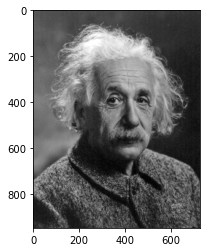

In [2]:
img = cv2.imread('../images/ein.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray');

In [3]:
numRows, numCols = img.shape

In [4]:
# a rep angle of rotation
a = 45

cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))

R = np.array([[cosa, -sina], 
              [sina, cosa]])

rMax, cMax = img.shape[0], img.shape[1]

# define the coordinates
cords = np.array([[0,0],
                  [0,cMax-1],
                  [rMax-1,0],
                  [rMax-1,cMax-1]])

In [5]:
print(R)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [6]:
cords.shape

(4, 2)

In [7]:
R.shape

(2, 2)

**N.B: Since cordinate and Rotational matrix does not have the same shape, make sure you rectify it using dot product.**

In [8]:
# .T is the transpose matrix
A_dash = R.dot(cords.T)
mins = A_dash.min(axis=1)
maxs = A_dash.max(axis=1)

# find the minimum row and column
minR = np.int64(np.floor(mins[0]))
minC= np.int64(np.floor(mins[1]))

# find the maximum row and column
maxR = np.int64(np.ceil(maxs[0]))
maxC = np.int64(np.ceil(maxs[1]))

# compute height and width
H,W = maxR-minR+1, maxC-minC+1

# define the resultant image
I2 = np.zeros((H,W),dtype="uint8")

In [9]:
A_dash.shape

(2, 4)

In [10]:
A_dash

array([[   0.        , -514.06662992,  670.33722856,  156.27059864],
       [   0.        ,  514.06662992,  670.33722856, 1184.40385849]])

In [11]:
mins,maxs

(array([-514.06662992,    0.        ]), array([ 670.33722856, 1184.40385849]))

In [12]:
I2.shape

(1187, 1186)

In [13]:
# bilinear interpolation

def bilinearInterpolate(row,col,I):
    lc = int(col)
    rc = lc + 1
    wr = col - lc
    wl = rc - col
    tr = int(row)
    br = tr + 1
    wt = br - row
    wb = row - tr
    if tr >= 0 and br < I.shape[0] and lc >= 0 and rc < I.shape[1]:
        a = wl * I[tr,lc] + I[tr,rc]
        b = wl * I[br,lc] + wr*I[br,rc]
        g = wt * a + wb * b

        return np.uint8(g)
    else:
        return 0

In [14]:
Tinv = np.linalg.inv(R)
for new_i in range(minR,maxR):
    for new_j in range(minC,maxC):
        P_dash = np.array([new_i,new_j])
        P = Tinv.dot(P_dash)
        i,j = P[0], P[1]
        if i < 0 or i >= numRows or j < 0 or j >= numCols:
            pass
        else:
            g = bilinearInterpolate(i,j,img)
            I2[new_i-minR,new_j-minC] = g

In [15]:
# display image as original

import matplotlib as mpl

def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

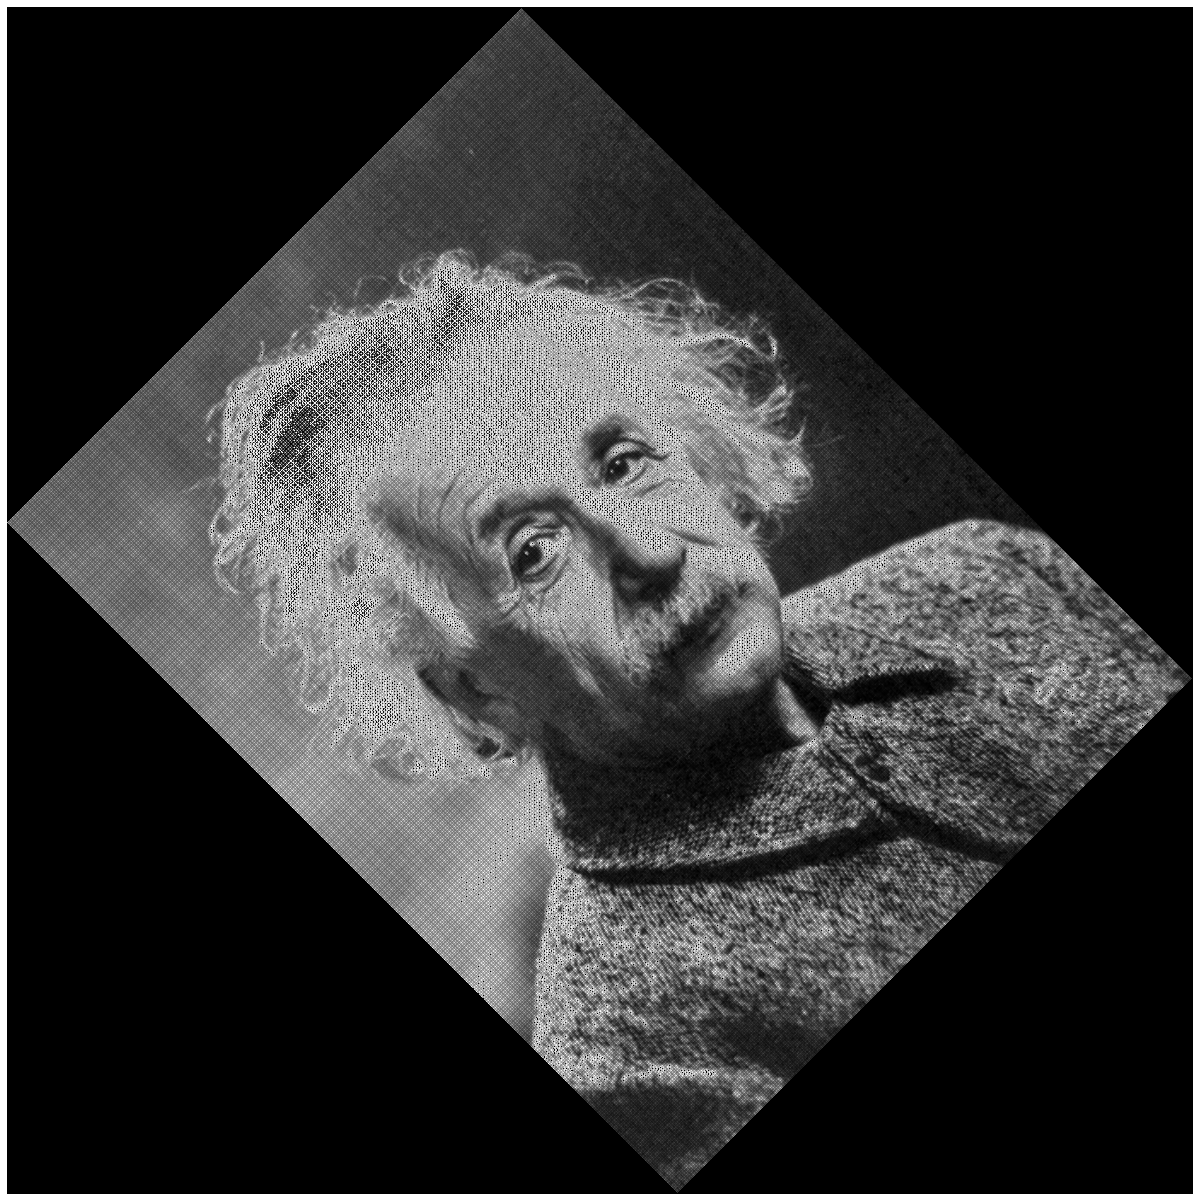

In [16]:
displayImageInActualSize(I2)

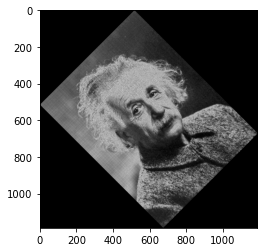

In [17]:
plt.imshow(I2, cmap="gray");

## Code Refactor

In [18]:
def f_getExtents(T,rMax,cMax):
    cords = np.array([[0,0],[0,cMax-1],[rMax-1,0],[rMax-1,cMax-1]])
    A_dash = T.dot(cords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [19]:
def f_transform(T, img):
    rMax,cMax = img.shape[0],img.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype="uint8")
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j])
            P = Tinv.dot(P_dash)
            i,j = P[0], P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = bilinearInterpolate(i,j,img)
                I2[new_i-minR,new_j-minC] = g
                
    return I2

**N.B:** The `f_transform` has a wide range of application. (i.e) It can be used for any 2D transformation (Scaling, Rotation, reflection, shear and so on...)

## 3. Reflection

Just like rotation is done at a particular point, reflection is done about axis of reflection. Either row or column axis.

* **To transform across row axis (Vertically - Mirror Image):**

$\begin{bmatrix}
-r \\
c \end{bmatrix}
= 
\begin{bmatrix}
-1 & 0 \\
0 & 1 \end{bmatrix}
\begin{bmatrix}
r \\
c \end{bmatrix}
$


* **To transform across column axis (Horizontally - Water Image):**

$\begin{bmatrix}
r \\
-c \end{bmatrix}
= 
\begin{bmatrix}
1 & 0 \\
0 & -1 \end{bmatrix}
\begin{bmatrix}
r \\
c \end{bmatrix}
$

In [20]:
# Transformation matrix

R = np.array([[-1,0],[0,1]])

R

array([[-1,  0],
       [ 0,  1]])

In [21]:
I2 = f_transform(R,img)

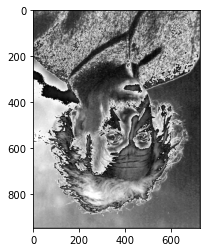

In [22]:
plt.imshow(I2,cmap="gray");

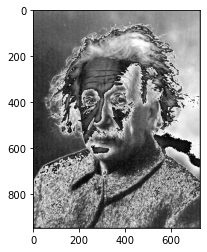

In [23]:
R = np.array([[1,0],[0,-1]])
I2 = f_transform(R,img)
plt.imshow(I2, cmap='gray')

## 4. Shear 

Like other transformation seen so far, shear is also a linear transformation.

![Shear tranformation](../images/shear.png)

The shearing matrix for `x-axis` is defined as:
$\begin{bmatrix}
r_2 \\
c_2 + kr_2 \end{bmatrix}
= 
\begin{bmatrix}
1 & 0 \\
k & 1 \end{bmatrix}
\begin{bmatrix}
r_2 \\
c_2 \end{bmatrix}
$

The shearing matrix for `y-axis` is defined as:
$\begin{bmatrix}
r_2 \\
c_2 + kr_2 \end{bmatrix}
= 
\begin{bmatrix}
1 & k \\
0 & 1 \end{bmatrix}
\begin{bmatrix}
r_2 \\
c_2 \end{bmatrix}
$


**N.B:** where `k` is the amount of shear.

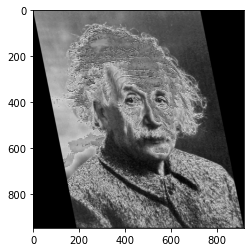

In [24]:
# Code Implementation for shear transformation

k = 0.2

# transformation matrix
T = np.array([[1,0],[k,1]])

# resultant image
I2 = f_transform(T, img)

# plot the image
plt.imshow(I2, cmap="gray");

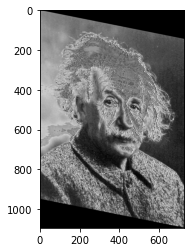

In [25]:
# shearing in y-axis

k = 0.2

# transformation matrix
T = np.array([[1,k],[0,1]])

# resultant image
I2 = f_transform(T, img)

# plot the image
plt.imshow(I2, cmap="gray");

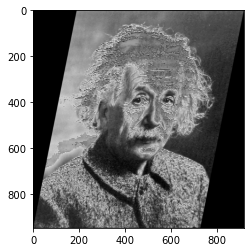

In [26]:
k = -0.2

# transformation matrix
T = np.array([[1,0],[k,1]])

# resultant image
I2 = f_transform(T, img)

# plot the image
plt.imshow(I2, cmap="gray");

## 5. Translation 

Translation is **not** a linear transformation. This is because no transformation matrix possible.

![translational](../images/translation.png)

$\begin{bmatrix}
r + t_r \\
c + t_c \end{bmatrix}
= 
\begin{bmatrix} \\
\end{bmatrix}
\begin{bmatrix}
r \\
c \end{bmatrix}
$

Hence, no matrix that can achieve the effect of translation. **Translation** due to its non linearity, it can therefore be solved with *Homogeneous coordinates*.

As in: Assume scale factor $\lambda \neq 0; \lambda = 2$

$\begin{bmatrix} 2 \\ 3 \end{bmatrix} \to \begin{bmatrix} 2 * \lambda \\ 3 * \lambda \\ \lambda \end{bmatrix} = \begin{bmatrix} 4 \\ 6 \\ 2\end{bmatrix}$

**N.B:** $\lambda$ may be any positive integer. However, the solution is called Homogeneous coordinate. Nonetheless, it is recommended that you assume $\lambda$ to be 1.

When we have the Homogenous matrix, it will be easy to determine the transformation matrix.

From the figure above, the homogeneous coordinates is $\begin{bmatrix} x_0 +Tx \\ y_0 + T_y \\ 1 \end{bmatrix}$. Therefore, 

$\begin{bmatrix} x_0 +Tx \\ y_0 + T_y \\ 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & T_x \\ 0 & 1 & T_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_0 \\ y_o \\ 1\end{bmatrix}$

**Transformation matrix for translation in 3x3 matrix**

$\begin{bmatrix}1 & 0 & t_r \\0 & 1 & t_c\\0 & 0 & 1\end{bmatrix}\begin{bmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta\end{bmatrix} \begin{bmatrix} S_x & 0\\0 & S_y\end{bmatrix} \begin{bmatrix}-1 & 0\\0 & 1\end{bmatrix} \begin{bmatrix} 1 & k\\ 0 & k\end{bmatrix} \begin{bmatrix} r \\ c \end{bmatrix}$

**Translation | Rotation | Scaling | Reflection | Shearing.** If this matrix from rotation to shearing are multiplied together, we can get a single matrix in 2x2 matrix.

But you have to convert it all to a 3x3 matrix, as in:

$\begin{bmatrix}1 & 0 & t_r \\0 & 1 & t_c\\0 & 0 & 1\end{bmatrix}\begin{bmatrix} cos\theta & -sin\theta & 0\\ sin\theta & cos\theta & 0 \\ 0&0&1\end{bmatrix} \begin{bmatrix} S_x & 0 & 0\\0 & S_y & 0 \\ 0&0&1\end{bmatrix} \begin{bmatrix}-1 & 0 & 0\\0 & 1 & 0 \\ 0&0&1\end{bmatrix} \begin{bmatrix} 1 & k & 0\\ 0 & k & 0 \\ 0&0&1\end{bmatrix} \begin{bmatrix} r \\ c \\ 1\end{bmatrix}$

Hence, 
$\begin{bmatrix}r'\\c'\\1\end{bmatrix} = A \begin{bmatrix}r\\c\\1\end{bmatrix}$

## 6. Affine transformation Implementation

The third row in the tanslation 3x3 matrix [0, 0, 1] is added but the other elements of the matrix is called `Affine transformation`.

Note that, you have to modify the `f_transform` and `f_getExtents` such that it will handle any form of transformation.

In [27]:
def f_getExtentsAffine(T,rMax,cMax):
    # all the cordinates are now homogeneous by adding 1
    cords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(cords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [28]:
def f_transformAffine(T, img):
    rMax,cMax = img.shape[0],img.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsAffine(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype="uint8")
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            # convert P_dash to homogeneous
            P_dash = np.array([new_i,new_j,1])
            P = Tinv.dot(P_dash)
            i,j = P[0], P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = bilinearInterpolate(i,j,img)
                I2[new_i-minR,new_j-minC] = g
                
    return I2

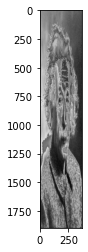

In [29]:
T = np.array([[2,0,10],[0,0.5,20],[0,0,1]])
I2 = f_transformAffine(T, img)
plt.imshow(I2, cmap='gray');

### 6.1 Rotation about any point

Assuming you want to rotate a point (3,4), using the rotational matrix:

$R = \begin{bmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \\ 0 & 0 & 1\end{bmatrix}$ 

It can only rotate the image about the **origin** not the point. Therefore, you have the **translate** the image before the rotation.

$T = \begin{bmatrix} 1 & 0 & -3 \\ 0 & 1 & -4 \\ 0 & 0 & 1\end{bmatrix}$ 

Total transformation:
$A = T^{-1} R T$ 

Hint: **First translate the image >> then rotate >> and then nullify the effect of translation.**

In [57]:
a = 30
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
R = np.array([[cosa,-sina,0],[sina,cosa,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
A = np.linalg.inv(T).dot(R).dot(T)

In [58]:
A

array([[  0.8660254 ,  -0.5       , 240.19237886],
       [  0.5       ,   0.8660254 , -96.41016151],
       [  0.        ,   0.        ,   1.        ]])

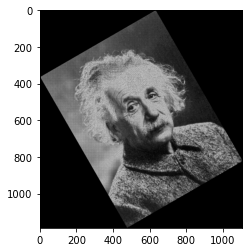

In [33]:
I2 = f_transformAffine(A, img)
plt.imshow(I2, cmap='gray');

In [59]:
a = 30
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
# rotation matrix
R = np.array([[cosa,-sina,0],[sina,cosa,0],[0,0,1]])
# translation matrix
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
# shear matrix
Sh = np.array([[1,0.5,0],[0,1,-400],[0,0,1]])
# scaling matrix
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)

In [60]:
A

array([[ 1.12583302e+00, -8.70834875e-02,  2.57083488e+02],
       [ 3.50000000e-01,  7.81217783e-01, -2.59974226e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

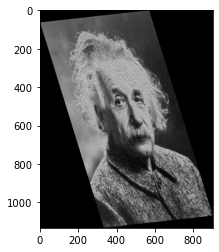

In [61]:
I2 = f_transformAffine(A, img)
plt.imshow(I2, cmap='gray');

In [62]:
plt.imsave('../images/affineImg.jpg',I2,cmap='gray')

### 6.2 Reflection about an arbitary line.

![reflect](../images/reflect.png)

The equation for the line is: $y = x + 2$  where y = row, x = col. Hence, $r = c + 2$

$A = T^{-1} R^{-1} R_f R T$

Hints:
* The line pass through the origin
* Translate the line
* Rotate the line
* Reflection
* Inverse Rotation and Translation

$r = mc + t$

In [37]:
a = -45

cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))

# translation
T = np.array([[1,0,-2],[0,1,0],[0,0,1]])

# rotation
R = np.array([[cosa,-sina,0],[sina,cosa,0],[0,0,1]])

# reflection
Rf = np.array([[1,0,0],[0,-1,0],[0,0,1]])

# Affine
A = np.linalg.inv(T).dot(np.linalg.inv(R)).dot(Rf).dot(T)

In [38]:
A

array([[ 0.70710678,  0.70710678,  0.58578644],
       [ 0.70710678, -0.70710678, -1.41421356],
       [ 0.        ,  0.        ,  1.        ]])

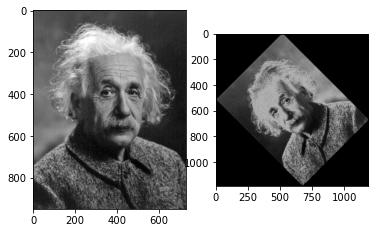

In [39]:
I2 = f_transformAffine(A, img)
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(I2, cmap='gray');

### 6.3 Transformation Matrix Properties

Representing all transformation matrix in Affine transformation:

$\begin{bmatrix} a&b&e \\ c&d&f\\ 0&0&1\end{bmatrix} \to \begin{bmatrix}\begin{bmatrix} a & b \\[5mm] c & d\end{bmatrix} && e \\ &&f \\ 0 & 0 &1 \end{bmatrix}$

e & f are the **translation parameters** and the $\begin{bmatrix}a&b \\ c&d \end{bmatrix}$ is the combination of **rotation, reflection, shear and scaling*.

Assuming $\begin{bmatrix}a&b \\ c&d \end{bmatrix} = B$ and if
$det(B) = 1 or -1$ and $inv(B) = B^T$ then B is an **Orthogonal Matrix**

* if det(B) = 1, it is Rotation.
* if det(B) = -1, it is Reflection.
* if B is diagonal, hence, it is Scaling.

In [40]:
a = 30
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
R = np.array([[cosa,-sina],[sina,cosa]])

In [41]:
np.linalg.det(R)

1.0

In [42]:
np.linalg.inv(R)

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

In [43]:
# transpose of Rotational matrix
R.T

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

**N.B: Since matrix determinant = 1 and inverse and transpose are the same, this therefore validates that it is Rotational transformation**

In [44]:
Rf = R[[1,0],:]

In [45]:
Rf

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [46]:
np.linalg.det(Rf)

-1.0

In [47]:
Rf.T

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [48]:
np.linalg.inv(Rf)

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

**N.B: Since matrix determinant = -1 and inverse and transpose are the same, this therefore validates that it is Reflection transformation**

### 6.4 Affine Transformation Hierarchy

**Affine 6dof**
$\begin{bmatrix}a_{11}&a_{12}&t_x\\a_{21}&a_{22}&t_y\\0&0&1\end{bmatrix}$

6 degrees of freedom i.e 6 matrix elements to define affine.

**Similarity 4dof**
$\begin{bmatrix}sr_{11}&sr_{12}&t_x\\sr_{21}&sr_{22}&t_y\\0&0&1\end{bmatrix}$

Total numbers of parameters are **4**. One for Scaling, One for rotation, two for translation.

**Euclidean 3dof**
$\begin{bmatrix}r_{11}&r_{12}&t_x\\r_{21}&r_{22}&t_y\\0&0&1\end{bmatrix}$

It is Orthogonal matrix. One parameter for Rotation while two for translation.

## 7. Projective Transformation (Homography)

$\begin{pmatrix}x'_1\\x'_2\\x'_3\end{pmatrix} = \begin{bmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\h_{31}&h_{32}&h_{33}\end{bmatrix}\begin{pmatrix}x_1\\x_2\\x_3\end{pmatrix}$

The effect of this transformation can be seen in different ways; for example, Camera used in taking picture. 

**N.B: Homography (out of plane transformation).** Homography(Projective) is different from homogenous(Affine) in the sense that $\lambda > or < 1$ 

In [49]:
def f_getExtentsProjective(T,rMax,cMax):
    # all the cordinates are now homogeneous by adding 1
    cords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(cords.T)
    # the modification
    A_dash = A_dash/A_dash[2,:]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [50]:
def f_transformProjective(T, img):
    rMax,cMax = img.shape[0],img.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsProjective(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype="uint8")
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            # convert P_dash to homogeneous
            P_dash = np.array([new_i,new_j,1])
            P = Tinv.dot(P_dash)
            # modification
            P = P/P[2]
            i,j = P[0], P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = bilinearInterpolate(i,j,img)
                I2[new_i-minR,new_j-minC] = g
                
    return I2

In [51]:
a = 30
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
# rotation matrix
R = np.array([[cosa,-sina,0],[sina,cosa,0],[0,0,1]])
# translation matrix
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
# shear matrix
Sh = np.array([[1,0.5,0],[0,1,-400],[0,0,1]])
# scaling matrix
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
# homography
H = A
H[2,:] = np.array([0.001,0.0001,1])

In [52]:
H

array([[ 1.12583302e+00, -8.70834875e-02,  2.57083488e+02],
       [ 3.50000000e-01,  7.81217783e-01, -2.59974226e+02],
       [ 1.00000000e-03,  1.00000000e-04,  1.00000000e+00]])

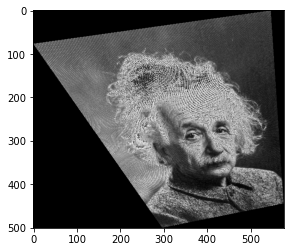

In [53]:
I2 = f_transformProjective(H, img)
plt.imshow(I2, cmap='gray');

In [56]:
plt.imsave('../images/projectiveImg.jpg',I2,cmap='gray')

**TODO:** *Watch video on how to make python code run faster. (Vectorization)*

### 7.1 Projective Warping Algorithm
Warping and transformation are used synonymous in Image processing or computer vision.

1. Image I, and Projective matrix H
1. Transfrom image extents to get the resultant image size
1. Initialize the resultant image with all zeros
1. Compute the inverse transfromation matrix: Tinv
1. For each pixel location (a,b,1) in resultant image:

    a. Apply Tinv on (a,b,1) and get (c,d) in the source image
    
    b. Apply interpolation on (c,d) and get intensity g
    
    c. Copy intensity g on location (a,b) in the resultant image.
    
**N.B: These are what working under the hood for any image processing libraries or packages: OpenCv or MatLab.**